In [1]:
%matplotlib ipympl
import numpy as np
from pathlib import Path
import utils as utils
import harp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import aeon.io.video as video
from ipywidgets import widgets
from IPython.display import display
import re
import os
from datetime import datetime
import datetime
import matplotlib.pyplot as plt

In [ ]:
## Load relevant data streams for all sessions ignoring olfactomer commands and output set/clear/analog data as some sessions are shaping and olfactometers not used

# Base directory for subject 026 (ID 077)
base_dir = Path('/Volumes/harris/hypnose/rawdata/sub-018_id-070')

# Find all session directories for this subject, filtering out non-directories
session_dirs = [d for d in base_dir.glob('ses-*_date-*/behav/*') if d.is_dir()]

print(f"Found {len(session_dirs)} sessions for subject 026 (ID 077)")

# Dictionary to store processed data for each session
sessions_data = {}

# Process each session
for session_dir in session_dirs:
    # Extract session ID from path
    session_match = re.search(r'ses-(\d+)_date-(\d+)', str(session_dir))
    if session_match:
        session_id = session_match.group(1)
        session_date = session_match.group(2)
    else:
        # Use directory name as fallback
        session_id = session_dir.parent.name
    
    try:
        print(f"\nProcessing session: {session_id} ({session_dir})")
        
        # Create readers for data formats
        behavior_reader = harp.reader.create_reader('device_schemas/behavior.yml', epoch=harp.io.REFERENCE_EPOCH)
        
        # Load the data streams
        try:
            digital_input_data = utils.load(behavior_reader.DigitalInputState, session_dir/"Behavior")
        except Exception:
            print(f"No digital_input_data found for session {session_id}. Assuming no pokes.")
            digital_input_data = None
        
        heartbeat = utils.load(behavior_reader.TimestampSeconds, session_dir/"Behavior")
        
        # 'other' events
        try:
            pulse_supply_1 = utils.load(behavior_reader.PulseSupplyPort1, session_dir/"Behavior")  # reward A pump end time
            r1_reward_count = len(pulse_supply_1)
        except Exception:
            r1_reward_count = 0
        
        try:
            pulse_supply_2 = utils.load(behavior_reader.PulseSupplyPort2, session_dir/"Behavior")  # reward B pump end time
            r2_reward_count = len(pulse_supply_2)
        except Exception:
            r2_reward_count = 0
        
        # Calculate session duration in seconds
        start_time_sec = heartbeat['TimestampSeconds'].iloc[0] if not heartbeat.empty else None
        end_time_sec = heartbeat['TimestampSeconds'].iloc[-1] if not heartbeat.empty else None

        if start_time_sec is not None and end_time_sec is not None:
            session_duration_sec = end_time_sec - start_time_sec
            
            # Convert to hours, minutes, seconds
            hours = int(session_duration_sec // 3600)
            minutes = int((session_duration_sec % 3600) // 60)
            seconds = int(session_duration_sec % 60)
            
            duration_str = f"{hours}h {minutes}m {seconds}s"
        else:
            session_duration_sec = None
            duration_str = "Unknown"
        
        # Extract event counts
        if digital_input_data is not None:
            r1_poke_count = digital_input_data['DIPort1'].sum() if 'DIPort1' in digital_input_data else 0
            r2_poke_count = digital_input_data['DIPort2'].sum() if 'DIPort2' in digital_input_data else 0
        else:
            r1_poke_count = 0
            r2_poke_count = 0
        
        # Store processed results in dictionary
        sessions_data[session_id] = {
            'dir': session_dir,
            'date': session_dir.stem,  # Using the timestamp as date
            'duration_sec': session_duration_sec,
            'duration': duration_str,
            'r1_pokes': r1_poke_count,
            'r2_pokes': r2_poke_count, 
            'r1_rewards': r1_reward_count,
            'r2_rewards': r2_reward_count,
        }
        
        print(f"Successfully processed session {session_id}")
        
    except Exception as e:
        print(f"Error processing session {session_id}: {e}")

# Display summary of loaded sessions
sessions_df = pd.DataFrame.from_dict(sessions_data, orient='index')
display(sessions_df)

# ...existing code...

Found 9 sessions for subject 026 (ID 077)

Processing session: 02 (/Volumes/harris/hypnose/rawdata/sub-018_id-070/ses-02_date-20250314/behav/2025-03-14T08-59-17)
Successfully processed session 02

Processing session: 08 (/Volumes/harris/hypnose/rawdata/sub-018_id-070/ses-08_date-20250325/behav/2025-03-25T09-06-42)
No digital_input_data found for session 08. Assuming no pokes.
Successfully processed session 08

Processing session: 04 (/Volumes/harris/hypnose/rawdata/sub-018_id-070/ses-04_date-20250318/behav/2025-03-18T09-02-42)
Successfully processed session 04

Processing session: 05 (/Volumes/harris/hypnose/rawdata/sub-018_id-070/ses-05_date-20250319/behav/2025-03-19T08-57-31)
Successfully processed session 05

Processing session: 06 (/Volumes/harris/hypnose/rawdata/sub-018_id-070/ses-06_date-20250321/behav/2025-03-21T09-16-05)
No digital_input_data found for session 06. Assuming no pokes.
Successfully processed session 06

Processing session: 01 (/Volumes/harris/hypnose/rawdata/sub-0

,dir,date,duration_sec,duration,r1_pokes,r2_pokes,r1_rewards,r2_rewards
02,/Volumes/harris/hypnose/rawdata/sub-018_id-070...,2025-03-14T08-59-17,10145,2h 49m 5s,2,0,1,0
08,/Volumes/harris/hypnose/rawdata/sub-018_id-070...,2025-03-25T09-06-42,9891,2h 44m 51s,0,0,0,0
04,/Volumes/harris/hypnose/rawdata/sub-018_id-070...,2025-03-18T09-02-42,10273,2h 51m 13s,0,0,0,0
05,/Volumes/harris/hypnose/rawdata/sub-018_id-070...,2025-03-19T08-57-31,10228,2h 50m 28s,0,0,0,0
06,/Volumes/harris/hypnose/rawdata/sub-018_id-070...,2025-03-21T09-16-05,10947,3h 2m 27s,0,0,0,0
01,/Volumes/harris/hypnose/rawdata/sub-018_id-070...,2025-03-13T09-06-08,10411,2h 53m 31s,0,1,0,0
09,/Volumes/harris/hypnose/rawdata/sub-018_id-070...,2025-03-28T09-08-39,9715,2h 41m 55s,0,0,0,0
03,/Volumes/harris/hypnose/rawdata/sub-018_id-070...,2025-03-17T08-49-08,10015,2h 46m 55s,1,0,1,0
07,/Volumes/harris/hypnose/rawdata/sub-018_id-070...,2025-03-24T09-33-03,14918,4h 8m 38s,0,0,0,0


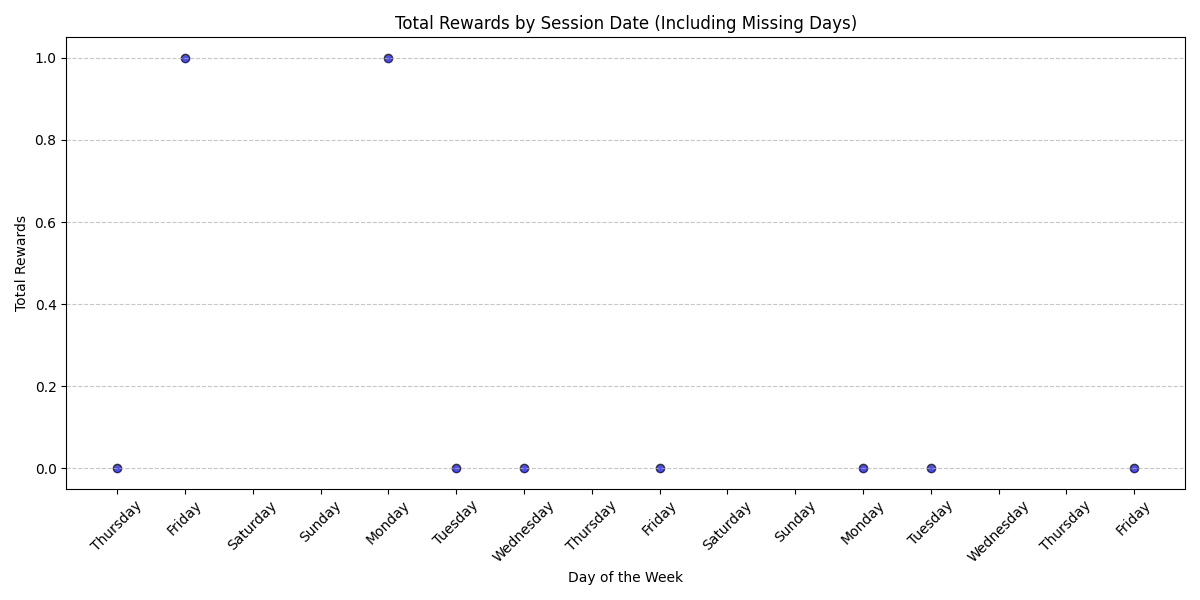

In [16]:
## Plotting total rewards by session date

# Add a column for total rewards and convert the date to a datetime object
sessions_df['total_rewards'] = sessions_df['r1_rewards'] + sessions_df['r2_rewards']
sessions_df['date'] = pd.to_datetime(sessions_df['date'], format='%Y-%m-%dT%H-%M-%S')

# Extract only the calendar date (ignoring time) for each session
sessions_df['calendar_date'] = sessions_df['date'].dt.date

# Add a column for the day of the week
sessions_df['day_of_week'] = pd.to_datetime(sessions_df['calendar_date']).dt.day_name()

# Create a complete date range from the first to the last session date
full_date_range = pd.date_range(start=sessions_df['calendar_date'].min(), 
                                end=sessions_df['calendar_date'].max(), freq='D')

# Create a new DataFrame with the full date range
full_sessions_df = pd.DataFrame({'calendar_date': full_date_range.date})

# Merge the original sessions_df with the full date range DataFrame
# This ensures that valid session data is preserved, and missing dates are filled with NaN
full_sessions_df = full_sessions_df.merge(sessions_df, on='calendar_date', how='left')

# Fill missing day_of_week values for the full date range
full_sessions_df['day_of_week'] = pd.to_datetime(full_sessions_df['calendar_date']).dt.day_name()

# Plot total rewards vs. session date
plt.figure(figsize=(12, 6))
plt.scatter(full_sessions_df['calendar_date'], full_sessions_df['total_rewards'], 
            color='blue', alpha=0.7, edgecolor='black')

# Customize the x-axis to show day names
day_labels = full_sessions_df['day_of_week'].values
plt.xticks(ticks=full_sessions_df['calendar_date'], labels=day_labels, rotation=45)

# Add labels and title
plt.xlabel('Day of the Week')
plt.ylabel('Total Rewards')
plt.title('Total Rewards by Session Date (Including Missing Days)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()